In [679]:
%autosave 300

Autosaving every 300 seconds


In [677]:
# from Cleanser import get_data, convert_time
from functools import reduce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib

import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets.samples_generator import make_blobs
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.spatial.distance import cdist, pdist
from datetime import datetime
sns.set(color_codes=True)
# matplotlib.style.use("ggplot")
%matplotlib inline

In [678]:
# print(plt.style.available)
print(matplotlib.matplotlib_fname())

# font_location = "C:Windows/Fonts/NanumBarunGothic.ttf"
# font_location = "/Users/RyuQae/Library/Fonts/NanumBarunGothic.otf"
font_location = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

print(matplotlib.rcParams["font.family"])

/home/ryuqae/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc
['NanumBarunGothic']


In [3]:
tidy_df = pd.read_pickle('output/tidy_df.pkl')

In [4]:
tidy_df.shape

(2153476, 18)

프라임타임 시간대(17시 이후부터) 1분 넘게 시청한 기록을 따로 분리하여 prime에 저장

In [135]:
prime = tidy_df[(tidy_df.시청시작시간.dt.hour >= 17) & (tidy_df.프로그램시청시간 > 60)].copy()

In [518]:
temp = prime.groupby(['기간', '일자', '요일', 'ID']).agg({'시청시작시간' : min, '시청종료시간' : max})

T2, T3, T4 전 기간에 걸쳐 패널로 등장하는 ID만을 대상으로 target_audience로 정의

In [519]:
ids = tidy_df.groupby('기간').ID.apply(set).reset_index().set_index('기간')
target_audience = list(ids.ID[0] & ids.ID[1] & ids.ID[2])

개별 시청자의 17시 이후 첫 시청기록의 시작시간으로 프라임타임 진입시간대 정의하고, 그날 마지막 시청기록의 시청종료시간으로 이탈시간대 정의

In [520]:
temp['진입시간대'] = temp.시청시작시간.dt.hour
temp['이탈시간대'] = temp.시청종료시간.dt.hour
temp.이탈시간대.replace({0:24, 1:25, 2:26, 3:27}, inplace=True)
temp.진입시간대.replace({0:24, 1:25, 2:26, 3:27}, inplace=True)

In [521]:
agg1 = {
    '프로그램시청시간' : {
        '시청시간' : 'sum'
    }
}

=====================================================================

In [496]:
pgenre_ratio = prime.groupby(['ID', '기간', '일자', '요일', '대분류'])\
    .agg({'프로그램시청시간':'sum'}).reset_index()

주중/주말을 나눠서 데이터프레임 저장

In [497]:
weekday = ['Mon','Tue','Wed','Thu','Fri']
weekend = ['Sat', 'Sun']
wkday = pgenre_ratio[pgenre_ratio.요일.isin(weekday)].copy()
wkend = pgenre_ratio[pgenre_ratio.요일.isin(weekend)].copy()

In [510]:
pvtd = pd.pivot_table(pgenre_ratio, 
                          values = '프로그램시청시간', 
                          index = ['기간', '일자', '요일', 'ID'], 
                          columns = '대분류').replace(np.nan, 0)

In [530]:
vector = pvtd.join(temp[['진입시간대','이탈시간대']]).reset_index()
vector.head(10)

,기간,일자,요일,ID,교육,기타,드라마&영화,보도,스포츠,어린이(유아),오락,정보,진입시간대,이탈시간대
0,T2,20160822,Mon,1401861aa,0.0,0.0,12553.0,1396.0,0.0,0.0,3465.0,2467.0,18,24
1,T2,20160822,Mon,1401861ab,0.0,0.0,12553.0,1396.0,0.0,0.0,3465.0,2467.0,18,24
2,T2,20160822,Mon,1401900ab,0.0,0.0,2820.0,0.0,0.0,0.0,360.0,0.0,22,23
3,T2,20160822,Mon,1401900ac,0.0,0.0,2820.0,0.0,0.0,0.0,2813.0,0.0,22,23
4,T2,20160822,Mon,1401908aa,0.0,0.0,420.0,4020.0,2424.0,0.0,120.0,4680.0,17,24
5,T2,20160822,Mon,1401908ab,0.0,0.0,420.0,3720.0,0.0,0.0,120.0,1200.0,22,24
6,T2,20160822,Mon,1401909aa,0.0,0.0,0.0,12041.0,0.0,0.0,1260.0,0.0,17,21
7,T2,20160822,Mon,1401917aa,0.0,0.0,0.0,0.0,0.0,2840.0,0.0,0.0,19,20
8,T2,20160822,Mon,1401917ab,0.0,0.0,0.0,4080.0,0.0,0.0,3565.0,0.0,21,23
9,T2,20160822,Mon,1401923aa,0.0,0.0,1920.0,0.0,357.0,0.0,0.0,0.0,22,23


In [531]:
wkday_v, wkend_v = vector[vector.요일.isin(weekday)], vector[vector.요일.isin(weekend)]

In [537]:
wkday_v.head(10)

,기간,일자,요일,ID,교육,기타,드라마&영화,보도,스포츠,어린이(유아),오락,정보,진입시간대,이탈시간대
0,T2,20160822,Mon,1401861aa,0.0,0.0,12553.0,1396.0,0.0,0.0,3465.0,2467.0,18,24
1,T2,20160822,Mon,1401861ab,0.0,0.0,12553.0,1396.0,0.0,0.0,3465.0,2467.0,18,24
2,T2,20160822,Mon,1401900ab,0.0,0.0,2820.0,0.0,0.0,0.0,360.0,0.0,22,23
3,T2,20160822,Mon,1401900ac,0.0,0.0,2820.0,0.0,0.0,0.0,2813.0,0.0,22,23
4,T2,20160822,Mon,1401908aa,0.0,0.0,420.0,4020.0,2424.0,0.0,120.0,4680.0,17,24
5,T2,20160822,Mon,1401908ab,0.0,0.0,420.0,3720.0,0.0,0.0,120.0,1200.0,22,24
6,T2,20160822,Mon,1401909aa,0.0,0.0,0.0,12041.0,0.0,0.0,1260.0,0.0,17,21
7,T2,20160822,Mon,1401917aa,0.0,0.0,0.0,0.0,0.0,2840.0,0.0,0.0,19,20
8,T2,20160822,Mon,1401917ab,0.0,0.0,0.0,4080.0,0.0,0.0,3565.0,0.0,21,23
9,T2,20160822,Mon,1401923aa,0.0,0.0,1920.0,0.0,357.0,0.0,0.0,0.0,22,23


클러스터링의 input vector로 사용할 column은 아래와 같다.

In [680]:
wkday_v.iloc[:,4:14].head(10)

,교육,기타,드라마&영화,보도,스포츠,어린이(유아),오락,정보,진입시간대,이탈시간대
0,0.0,0.0,12553.0,1396.0,0.0,0.0,3465.0,2467.0,18,24
1,0.0,0.0,12553.0,1396.0,0.0,0.0,3465.0,2467.0,18,24
2,0.0,0.0,2820.0,0.0,0.0,0.0,360.0,0.0,22,23
3,0.0,0.0,2820.0,0.0,0.0,0.0,2813.0,0.0,22,23
4,0.0,0.0,420.0,4020.0,2424.0,0.0,120.0,4680.0,17,24
5,0.0,0.0,420.0,3720.0,0.0,0.0,120.0,1200.0,22,24
6,0.0,0.0,0.0,12041.0,0.0,0.0,1260.0,0.0,17,21
7,0.0,0.0,0.0,0.0,0.0,2840.0,0.0,0.0,19,20
8,0.0,0.0,0.0,4080.0,0.0,0.0,3565.0,0.0,21,23
9,0.0,0.0,1920.0,0.0,357.0,0.0,0.0,0.0,22,23


우선 주중 장르별 시청시간에 대하여 각각 Standard Scaler와 MinMax Scaler로 Scale을 조정한다.

In [670]:
wkday_std = StandardScaler().fit_transform(wkday_v.iloc[:,4:14])
wkday_Mm = MinMaxScaler().fit_transform(wkday_v.iloc[:,4:14])

## DBSCAN

In [703]:
def do_dbscan(df, eps):
    start = datetime.now()
    db = DBSCAN(eps=eps).fit(df)
    print("Finished Learning: ",datetime.now() - start)
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("The Number of Clusters: ", n_clusters_)
    
    major_groups = np.arange(-1, n_clusters_)[np.bincount(labels+1) > 500].tolist()
    print("Major Groups are ", major_groups)
    
    return labels, major_groups

두 가지 처리한 vector를 입력값으로 각각 DBSCAN 클러스터링

In [730]:
std_labels, std_groups = do_dbscan(wkday_std, 0.08)

Finished Learning:  0:00:24.221962
The Number of Clusters:  377
Major Groups are  [-1, 0, 6, 17, 21]


In [705]:
mm_labels, mm_groups = do_dbscan(wkday_Mm, 0.02)

Finished Learning:  0:00:08.017468
The Number of Clusters:  513
Major Groups are  [-1, 0, 2, 3, 4, 5, 6, 7, 11, 16, 17, 27, 28, 30, 49]


In [760]:
wkday_v[std_labels == 21].head(20)

,기간,일자,요일,ID,교육,기타,드라마&영화,보도,스포츠,어린이(유아),오락,정보,진입시간대,이탈시간대
363,T2,20160822,Mon,1402499ab,0.0,0.0,0.0,300.0,0.0,0.0,0.0,0.0,17,17
364,T2,20160822,Mon,1402501aa,0.0,0.0,0.0,2580.0,0.0,0.0,0.0,0.0,17,17
551,T2,20160822,Mon,1402716ab,0.0,0.0,0.0,2425.0,0.0,0.0,120.0,120.0,17,17
930,T2,20160822,Mon,2402533aa,0.0,0.0,0.0,0.0,0.0,0.0,1620.0,0.0,17,17
1263,T2,20160822,Mon,2403061aa,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.0,17,17
1560,T2,20160822,Mon,2403377aa,0.0,0.0,0.0,1320.0,0.0,0.0,0.0,0.0,17,17
1572,T2,20160822,Mon,2403398aa,0.0,0.0,0.0,2220.0,0.0,0.0,240.0,0.0,17,17
2010,T2,20160822,Mon,2403887aa,0.0,0.0,0.0,660.0,0.0,0.0,0.0,0.0,17,17
2107,T2,20160822,Mon,2403981ab,0.0,0.0,0.0,1645.0,0.0,0.0,0.0,180.0,17,17
2185,T2,20160822,Mon,2404075ab,0.0,0.0,0.0,660.0,0.0,0.0,0.0,0.0,17,17


## K-Means

In [739]:
def do_kmeans(df, k_range=range(2,30)):
    KMs = []
    Ls = []

    start = datetime.now()
    for n_clusters in k_range:
        print("k: ", n_clusters, "centroids")
        kmeans = KMeans(n_clusters=n_clusters).fit(df)
        labels = kmeans.labels_
        KMs.append(kmeans)
        Ls.append(labels)
    print("Finished Learning: ",datetime.now() - start)
    
    centroids = [k.cluster_centers_ for k in KMs]
    D_k = [cdist(df, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/df.shape[0] for d in dist]
    
    return KMs, Ls, centroids, avgWithinSS, cIdx

In [740]:
# Run only one of either
kms, labs, cents, awss, cidx = do_kmeans(wkday_std)
# kms, labs, cents, awss, cidx = do_kmeans(wkday_Mm)

k:  2 centroids
k:  3 centroids
k:  4 centroids
k:  5 centroids
k:  6 centroids
k:  7 centroids
k:  8 centroids
k:  9 centroids
k:  10 centroids
k:  11 centroids
k:  12 centroids
k:  13 centroids
k:  14 centroids
k:  15 centroids
k:  16 centroids
k:  17 centroids
k:  18 centroids
k:  19 centroids
k:  20 centroids
k:  21 centroids
k:  22 centroids
k:  23 centroids
k:  24 centroids
k:  25 centroids
k:  26 centroids
k:  27 centroids
k:  28 centroids
k:  29 centroids
Finished Learning:  0:02:35.062194


In [931]:
# elbow curve

def elbow(awss, kIdx = 18, k_range=range(2,30)):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    ax.plot(k_range, awss, '*-')
    ax.plot(k_range[kIdx], awss[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='hotpink', markerfacecolor='None')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for K-means clustering')

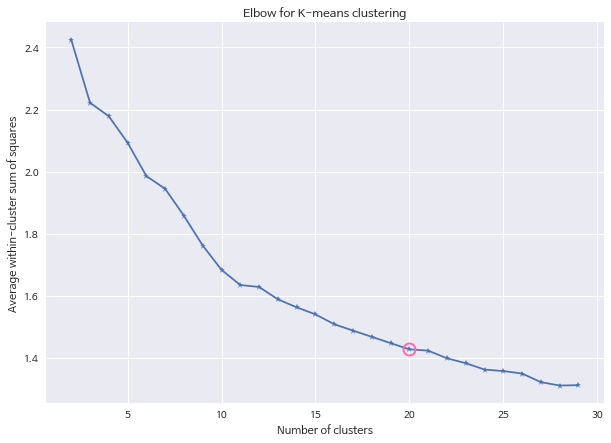

In [932]:
elbow(awss)

## PCA for Visualization

In [780]:
pca = PCA(n_components=2)
projection = pd.DataFrame(pca.fit_transform(wkday_std))
projection.columns = ['first', 'second']
projection['group'] = labs[18]

# major = projection[projection.group.isin(major_groups)]

In [782]:
projection.tail(10)

,first,second,group
64602,0.516331,3.039026,11
64603,-1.861004,-2.813387,18
64604,-0.654500,-2.311736,18
64605,1.142359,0.284985,15
64606,1.142359,0.284985,15
64607,0.027156,1.351655,16
64608,-0.600381,1.814534,16
64609,-0.369315,1.184599,9
64610,0.041248,-0.423312,0
64611,0.041248,-0.423312,0


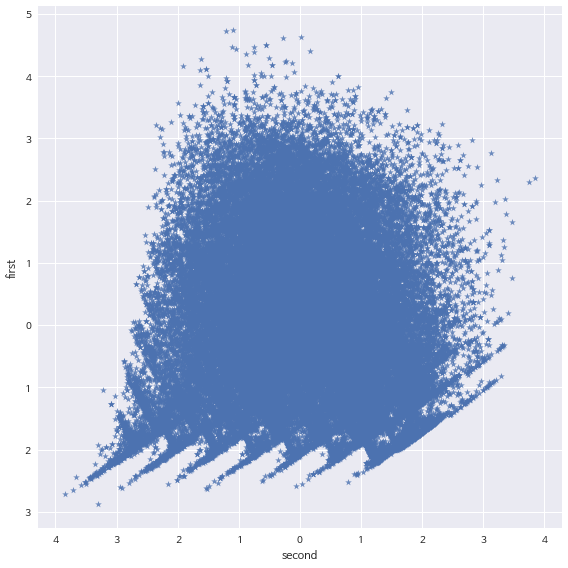

In [798]:
sns.lmplot("second", "first", data=projection, fit_reg=False, size=8, markers='*')

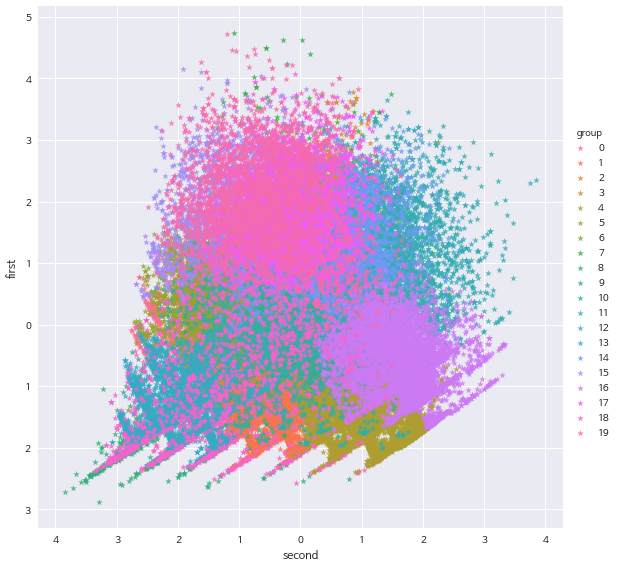

In [799]:
sns.lmplot("second", "first", data=projection, 
           fit_reg=False, size=8, hue="group", legend=True, markers='*')

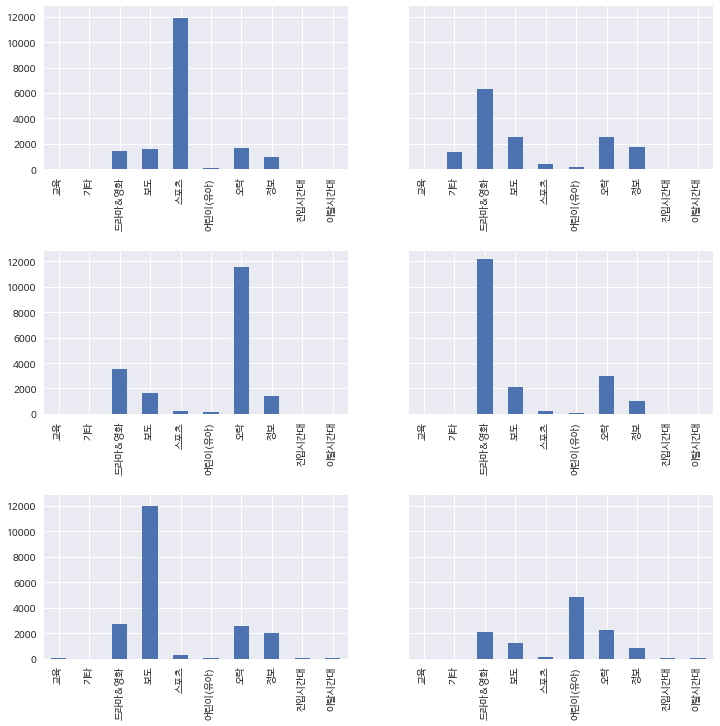

In [855]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, )
fig.subplots_adjust(hspace=.5)

wkday_v[labs[18] == 3].describe().loc['mean']\
    .plot(kind='bar', figsize=(12,12), ax=axes[0,0])
wkday_v[labs[18] == 6].describe().loc['mean']\
    .plot(kind='bar', figsize=(12,12), ax=axes[0,1])
wkday_v[labs[18] == 11].describe().loc['mean']\
    .plot(kind='bar', figsize=(12,12), ax=axes[1,0])
wkday_v[labs[18] == 14].describe().loc['mean']\
    .plot(kind='bar', figsize=(12,12), ax=axes[1,1])
wkday_v[labs[18] == 15].describe().loc['mean']\
    .plot(kind='bar', figsize=(12,12), ax=axes[2,0])
wkday_v[labs[18] == 18].describe().loc['mean']\
    .plot(kind='bar', figsize=(12,12), ax=axes[2,1])


# plt.ylim(0,10000)

In [794]:
wkday_v[labs[18] == 3].describe()

,교육,기타,드라마&영화,보도,스포츠,어린이(유아),오락,정보,진입시간대,이탈시간대
count,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000
mean,6.169154,1.865672,1412.247512,1620.340796,11902.427861,82.077114,1679.854478,972.667910,17.788557,23.114428
std,74.364095,31.278317,2070.076700,2042.911031,2828.047315,487.760245,2338.029937,1602.817028,0.942992,1.099911
min,0.000000,0.000000,0.000000,0.000000,8699.000000,0.000000,0.000000,0.000000,17.000000,20.000000
25%,0.000000,0.000000,0.000000,0.000000,9880.000000,0.000000,0.000000,0.000000,17.000000,22.000000
50%,0.000000,0.000000,138.500000,840.000000,11160.000000,0.000000,420.000000,120.000000,18.000000,23.000000
75%,0.000000,0.000000,2396.250000,2732.250000,13268.000000,0.000000,2831.250000,1399.000000,18.000000,24.000000
max,1581.000000,660.000000,12180.000000,12405.000000,26888.000000,6006.000000,14144.000000,11245.000000,22.000000,25.000000


## TVPro2Vec

In [857]:
from gensim.models import word2vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO )

In [861]:
watched = tidy_df[tidy_df.프로그램시청시간 >= 600].copy()

In [870]:
daily_programs = watched.groupby(['ID','일자']).프로그램명.apply(list).tolist()
whole_programs = watched.groupby(['ID']).프로그램명.apply(list).tolist() 

In [874]:
len(daily_programs)
len(whole_programs)

4660

In [875]:
# model = gensim.models.Word2Vec(programs, min_count=1)
daily_model = word2vec.Word2Vec(programs, size=300, window=10, min_count=5, workers=8)

2017-06-08 03:25:33,905 : INFO : collecting all words and their counts
2017-06-08 03:25:33,905 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-06-08 03:25:33,928 : INFO : PROGRESS: at sentence #10000, processed 91295 words, keeping 4250 word types
2017-06-08 03:25:33,956 : INFO : PROGRESS: at sentence #20000, processed 179628 words, keeping 5357 word types
2017-06-08 03:25:33,981 : INFO : PROGRESS: at sentence #30000, processed 261748 words, keeping 5906 word types
2017-06-08 03:25:34,006 : INFO : PROGRESS: at sentence #40000, processed 354513 words, keeping 6352 word types
2017-06-08 03:25:34,024 : INFO : PROGRESS: at sentence #50000, processed 443659 words, keeping 6654 word types
2017-06-08 03:25:34,047 : INFO : PROGRESS: at sentence #60000, processed 524999 words, keeping 6821 word types
2017-06-08 03:25:34,065 : INFO : PROGRESS: at sentence #70000, processed 605345 words, keeping 6973 word types
2017-06-08 03:25:34,083 : INFO : PROGRESS: at sentence

In [876]:
model.most_similar(positive=['JTBC뉴스룸'], topn=20)

2017-06-08 03:25:47,120 : INFO : precomputing L2-norms of word weight vectors


[('MBN뉴스8', 0.7447007894515991),
 ('TV조선뉴스판', 0.7300010919570923),
 ('5시정치부회의', 0.7111740708351135),
 ('MBN뉴스와이드', 0.6718124151229858),
 ('최희준의왜', 0.6323822736740112),
 ('박종진라이브쇼', 0.6258902549743652),
 ('채널A종합뉴스', 0.6242173910140991),
 ('김선영의뉴스나이트', 0.6084328889846802),
 ('알짜왕', 0.5985866785049438),
 ('정연욱의쾌도난마', 0.5985335111618042),
 ('SBS8뉴스', 0.5964147448539734),
 ('4시사건반장', 0.5853511095046997),
 ('김승련의뉴스TOP10', 0.5749503374099731),
 ('뉴스리뷰1부', 0.571458101272583),
 ('말로하는버스킹말하는대로', 0.568199634552002),
 ('오늘굿데이', 0.5675162076950073),
 ('전원책의이것이정치다', 0.5613279342651367),
 ('썰전', 0.5425420999526978),
 ('외부자들<재>', 0.5398827791213989),
 ('JTBC뉴스현장', 0.5391479730606079)]

In [878]:
model.most_similar(positive=['슈퍼맨이돌아왔다'], topn=20)

[('1박2일3', 0.830406665802002),
 ('해피투게더시즌3', 0.7492955327033997),
 ('런닝맨', 0.6833585500717163),
 ('나혼자산다', 0.6498875021934509),
 ('황금어장', 0.6363421082496643),
 ('님과함께2최고의사랑', 0.628767728805542),
 ('비하인드더팩트용감한기자들3', 0.6248363256454468),
 ('무한도전', 0.6227706074714661),
 ('미운우리새끼다시쓰는육아일기', 0.6209015846252441),
 ('판타스틱듀오', 0.5811688899993896),
 ('신동엽성시경은오늘뭐먹지', 0.5563063025474548),
 ('너의목소리가보여3', 0.5332844853401184),
 ('엄마가뭐길래', 0.5303930640220642),
 ('특별기자회견용감한기자들', 0.525718092918396),
 ('어쩌다어른강연쇼설민석편', 0.5197878479957581),
 ('연예가중계랭킹쇼', 0.5147834420204163),
 ('달려라치킨미니어쳐공작소', 0.5144282579421997),
 ('TASTYROAD2016', 0.5055972337722778),
 ('아는형님', 0.501183807849884),
 ('미스터리음악쇼복면가왕', 0.4938815236091614)]

In [880]:
model.most_similar(positive=['쓸쓸하고찬란하신도깨비'], topn=20)

[('리얼막장모험활극신서유기3', 0.8151886463165283),
 ('골든탬버린', 0.7912754416465759),
 ('탈탈터는꿀조합레시피편의점을털어라', 0.7792590856552124),
 ('미씽나인', 0.7733920812606812),
 ('놓치지말아야할소리보이스', 0.7697107791900635),
 ('어쩌다어른', 0.7506570219993591),
 ('팬텀싱어<재>', 0.7491190433502197),
 ('월화드라마(내성적인보스)', 0.7453672289848328),
 ('푸른바다의전설', 0.7442022562026978),
 ('역도요정김복주', 0.738681435585022),
 ('금토드라마(솔로몬의위증스페셜)', 0.730879545211792),
 ('금토드라마(솔로몬의위증<재>)', 0.7257280945777893),
 ('쓸쓸하고찬란하신도깨비<본>', 0.7221032381057739),
 ('립스틱프린스', 0.721331000328064),
 ('화랑', 0.7118257880210876),
 ('상속자들', 0.6888235807418823),
 ('외부자들<재>', 0.6867001056671143),
 ('말로하는버스킹말하는대로스페셜', 0.6833354234695435),
 ('인생술집', 0.6822945475578308),
 ('아버님제가모실게요', 0.6772845983505249)]

In [882]:
model['쓸쓸하고찬란하신도깨비']

array([ 0.56934726, -0.24161766, -0.57152766, -1.30692589,  1.65548348,
        0.54443669, -0.40362102, -0.42574769, -0.85517973,  0.00863599,
        0.38455677, -0.43443748,  0.52571303, -0.24061786,  0.69915491,
       -0.97940034, -1.17204666,  0.56464678,  1.34063983, -0.27477771,
       -1.17588699, -1.11542439, -0.81003731, -0.26529425, -0.27713653,
        0.2641885 ,  0.82258379, -0.57112741,  0.55898345,  0.72587067,
        0.86118191, -0.63948047,  0.87718338, -0.31764692, -1.01315689,
       -0.17641482,  0.88231087, -0.09207231, -0.77348918,  0.46316519,
        0.37229389, -1.2505306 , -1.21041703, -0.39102045, -0.15637977,
       -1.09234703,  0.67009652,  0.13711558, -0.18469882,  0.82125711,
       -1.28023565, -0.4938612 ,  0.51913649,  1.67435133,  0.91986889,
       -0.43137202,  0.43191901,  0.52931744, -0.11045284, -0.15989642,
        0.30537853,  0.12347379,  0.90563142, -0.80170071,  1.54386353,
        0.39030334,  0.74712038, -0.21276915,  0.22423337, -0.52

In [926]:
whole_model = word2vec.Word2Vec(whole_programs, size=300, window=30, min_count=5, workers=8)

2017-06-08 03:54:15,401 : INFO : collecting all words and their counts
2017-06-08 03:54:15,402 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-06-08 03:54:15,553 : INFO : collected 7519 word types from a corpus of 922540 raw words and 4660 sentences
2017-06-08 03:54:15,554 : INFO : Loading a fresh vocabulary
2017-06-08 03:54:15,565 : INFO : min_count=5 retains 5164 unique words (68% of original 7519, drops 2355)
2017-06-08 03:54:15,566 : INFO : min_count=5 leaves 917254 word corpus (99% of original 922540, drops 5286)
2017-06-08 03:54:15,578 : INFO : deleting the raw counts dictionary of 7519 items
2017-06-08 03:54:15,580 : INFO : sample=0.001 downsamples 73 most-common words
2017-06-08 03:54:15,580 : INFO : downsampling leaves estimated 807505 word corpus (88.0% of prior 917254)
2017-06-08 03:54:15,581 : INFO : estimated required memory for 5164 words and 300 dimensions: 14975600 bytes
2017-06-08 03:54:15,595 : INFO : resetting layer weights
2017-06-08 

In [927]:
whole_model.most_similar(positive=['가요무대'], topn=20)

2017-06-08 03:54:36,458 : INFO : precomputing L2-norms of word weight vectors


[('우리말겨루기', 0.7682617902755737),
 ('시사기획창', 0.7020153999328613),
 ('이웃집찰스', 0.6588712930679321),
 ('뮤직토크쇼가요1번지', 0.645085871219635),
 ('나눔경영쇼사장님이미쳤어요<재>', 0.6005738377571106),
 ('달라졌어요', 0.5826709270477295),
 ('명불허전', 0.5826529264450073),
 ('시니어토크쇼황금연못<재>', 0.5759097337722778),
 ('어부의만찬', 0.5757573843002319),
 ('BBC휴먼기획공룡의시대', 0.5711387991905212),
 ('자전거식객', 0.561493992805481),
 ('내고향스페셜', 0.5601133108139038),
 ('멜로다큐(가족)', 0.5599641799926758),
 ('KBS뉴스(24:10)', 0.5584990978240967),
 ('통일전망대', 0.5458662509918213),
 ('KBS네트워크특선밥상의전설', 0.5454798340797424),
 ('열린음악회', 0.544276773929596),
 ('창사특집8부작UHD다큐(인천의힘)', 0.5431278347969055),
 ('인간극장스페셜<재>', 0.5380395650863647),
 ('순간포착세상에이런일이<재>', 0.5342864990234375)]

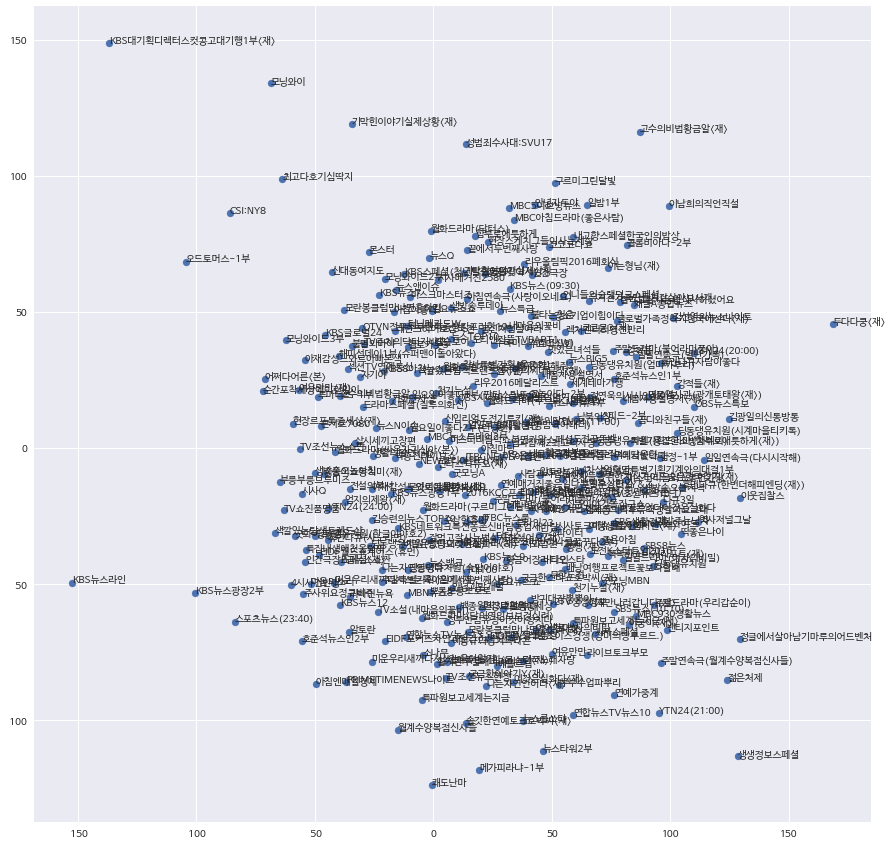

In [928]:
wv, vocabulary = whole_model[whole_model.wv.vocab], whole_model.wv.vocab

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(wv[500:800,:])

plt.figure(figsize=(15,15))
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(vocabulary, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()